##### Instructions #####

1) Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2) Reduce the size of the network using a method such as the island method described in Chapter 4 of social network analysis.
3) What can you infer about each of the distinct groups?

In [74]:
# Core libraries
import matplotlib.pyplot as plt
import networkx as nx
#print(nx.__version__)
from networkx.algorithms import bipartite
from networkx.algorithms import community
import numpy as np
import seaborn as sns
import pandas as pd

##### Dataset Info & Source #####

https://snap.stanford.edu/data/wiki-Elec.html 

Wikipedia is a free encyclopedia written collaboratively by volunteers around the world. A small part of Wikipedia contributors are administrators, who are users with access to additional technical features that aid in maintenance. For a user to become an administrator, a Request for Adminship (RfA) is issued, and the Wikipedia community, via a public discussion or a vote, decides who to promote to adminship. Using the latest complete dump of Wikipedia page edit history (from January 3, 2008), we extracted all administrator elections and vote history data. This gave us nearly 2,800 elections with around 100,000 total votes and about 7,000 users participating in the elections (either casting a vote or being voted on). Out of these 1,200 elections resulted in a successful promotion, while about 1,500 elections did not result in the promotion. About half of the votes in the dataset are by existing admins, while the other half comes from ordinary Wikipedia users.

##### Dataset Format & Features #####

The dataset has the following format:

   E: Did the elector result in promotion (1) or not (0)
   T: The time the election was closed
   U: User ID (and screen name) of editor that is being considered for promotion
   N: User ID (and screen name) of the nominator
   V: Vote (1:support, 0:neutral, -1:oppose) user_id time screen_name

In [7]:
# Load data from SNAP directly
import gzip
import requests
import io

url = "https://snap.stanford.edu/data/wikiElec.ElecBs3.txt.gz"
r = requests.get(url)
f = gzip.open(io.BytesIO(r.content), mode='rt', encoding='utf-8', errors='ignore')

# Inspect structure
for i, line in enumerate(f):
    if i < 25:
        print(line.strip())

# Wikipedia elections (http://cs.stanford.edu/people/jure/pubs/triads-chi10.pdf). Data format:
#   E: is election succesful (1) or not (0)
#   T: time election was closed
#   U: user id (and username) of editor that is being considered for promotion
#   N: user id (and username) of the nominator
#   V: <vote(1:support, 0:neutral, -1:oppose)> <user_id> <time> <username>
E	1
T	2004-09-21 01:15:53
U	30	cjcurrie
N	32	andyl
V	1	3	2004-09-14 16:26:00	ludraman
V	-1	25	2004-09-14 16:53:00	blankfaze
V	1	4	2004-09-14 17:08:00	gzornenplatz
V	1	5	2004-09-14 17:37:00	orthogonal
V	1	6	2004-09-14 19:28:00	andrevan
V	1	7	2004-09-14 19:37:00	texture
V	1	8	2004-09-14 21:04:00	lst27
V	1	9	2004-09-14 21:30:00	mirv
V	1	10	2004-09-14 22:13:00	anárion
V	0	26	2004-09-14 22:18:00	grunt
V	0	27	2004-09-15 03:19:00	slowking
V	0	28	2004-09-15 03:20:00	neutrality
V	1	11	2004-09-15 04:28:00	merovingian
V	1	12	2004-09-15 06:56:00	wile
V	1	13	2004-09-15 09:19:00	sjc


This is the structure of the dataset; we see general info for each election (E, T, U, N), along with many V's for each election. The V lines are the individual edges connecting voters to candidates. I will parse the data line by line, for each unique value of E. For each V line, I will extract the candidate ID (U), voter ID (from V), vote value (support/neutral/oppose), election outcome (E), and election close time (T). 

In [46]:
# GitHub file URL
url = "https://github.com/RonBalaban/CUNY-SPS/blob/main/DATA620/Project2/wikiElec.ElecBs3.txt"

# Convert to raw URL- as it is too large to access directly
raw_url = url.replace("github.com", "raw.githubusercontent.com").replace("/blob", "")

# Load file
print("Downloading data from:", raw_url)
r = requests.get(raw_url)
r.raise_for_status()
# read text content into memory as a file-like object
data = io.StringIO(r.text)

print("______________________________________________________________________________________________________________________________")
# Initialize lists to store elections and individual vote edges
elections = []
edges = []
current_election = {}

# Parser
for line in data:
    line = line.strip()
    # skip empty lines and comments
    if not line or line.startswith("#"):
        continue
    parts = line.split("\t")
    # first element identifies line type (E, T, U, N, V)
    prefix = parts[0]

    if prefix == "E":
        # Start of a new election; save previous election if it exists
        if current_election and "candidate_id" in current_election:
            elections.append(current_election)
        # store election outcome
        current_election = {"result": int(parts[1]), "votes": []}

    elif prefix == "T":
        # Election close time
        current_election["close_time"] = parts[1]

    elif prefix == "U":
        # Candidate information: ID and (optional) name
        current_election["candidate_id"] = parts[1]
        current_election["candidate_name"] = parts[2] if len(parts) > 2 else None

    elif prefix == "N":
        # Nominator information: ID and (optional) name
        current_election["nominator_id"] = parts[1]
        current_election["nominator_name"] = parts[2] if len(parts) > 2 else None

    elif prefix == "V":
        # Vote line: "V" <vote> <voter_id> <time> <voter_name>
        if len(parts) >= 5:
            edges.append({
                "candidate_id": current_election.get("candidate_id"),
                "voter_id": parts[2],      # voter node ID
                "vote": int(parts[1]),     # vote value (+1, 0, -1)
                "time": parts[3],          # vote timestamp
                "voter_name": parts[4]     # voter username
            })

# Add the last election after finishing the loop
if current_election and "candidate_id" in current_election:
    elections.append(current_election)

# Summary
print(f" Total votes parsed: {len(edges):,}")
print(f" Total elections parsed: {len(elections):,}")
if edges:
    print("Sample record:", edges[0])
else:
    print("Error: Still no votes found — check file content preview.")

______________________________________________________________________________________________________________________________
 Total votes parsed: 114,040
 Total elections parsed: 2,794
Sample record: {'candidate_id': '30', 'voter_id': '3', 'vote': 1, 'time': '2004-09-14 16:26:00', 'voter_name': 'ludraman'}


I also want to see the most succesful candidates, based on percentages and totals. 

In [52]:
# Votes for each Candidate

df_edges = pd.DataFrame(edges)

# Group by candidate and count vote types (as fractions)
vote_summary = df_edges.groupby('candidate_id')['vote'].value_counts(normalize=True).unstack(fill_value=0)
vote_summary = (vote_summary * 100).round(2)

# Total votes per candidate
vote_summary['total_votes'] = df_edges.groupby('candidate_id')['vote'].count()

# Rename columns 
vote_summary = vote_summary.rename(columns={-1: 'oppose', 0: 'neutral', 1: 'support'})

# Sort by total votes
vote_summary = vote_summary.sort_values(by='total_votes', ascending=False)

# Top 10 candidates
top_candidates_votes = vote_summary.head(10)
print(top_candidates_votes)

print("______________________________________________________________________________________________________________________________")
# Voter Score

# Count number of each vote type per candidate
vote_counts = df_edges.groupby(['candidate_id', 'vote']).size().unstack(fill_value=0)

# Rename columns 
vote_counts = vote_counts.rename(columns={-1: 'oppose', 0: 'neutral', 1: 'support'})

# Compute vote_score 
vote_counts['vote_score'] = vote_counts['support'] - vote_counts['oppose']

# Add total votes, fixed
vote_counts['total_votes'] = vote_counts[['oppose','neutral','support']].sum(axis=1)


# Reset index to have candidate_id as a column
vote_counts = vote_counts.reset_index()

# Sort by vote_score descending
vote_counts = vote_counts.sort_values('vote_score', ascending=False)
vote_counts.head()

vote          oppose  neutral  support  total_votes
candidate_id                                       
4037           28.13     4.55    67.32          615
2625           11.03     5.87    83.10          426
2565           34.37    11.22    54.42          419
1297           23.87     5.25    70.88          419
2398           30.50     5.50    64.00          400
15             30.27     2.43    67.30          370
762            35.59     6.21    58.19          354
4191           33.62     7.54    58.84          345
3089           16.36     7.27    76.36          330
1549           19.08     8.92    72.00          325
______________________________________________________________________________________________________________________________


vote,candidate_id,oppose,neutral,support,vote_score,total_votes
594,2625,47,25,354,307,426
491,2328,6,6,264,258,276
845,3352,31,7,275,244,313
1055,4037,173,28,414,241,615
629,271,21,10,246,225,277


In [51]:
# Get the names

# Build candidate_id to candidate_name mapping
candidate_names = pd.DataFrame([
    # Query pull
    {"candidate_id": e["candidate_id"], "candidate_name": e.get("candidate_name")}
    for e in elections
]).drop_duplicates()

# Make candidate_id is string to match vote_counts
candidate_names["candidate_id"] = candidate_names["candidate_id"].astype(str)
vote_counts["candidate_id"] = vote_counts["candidate_id"].astype(str)

# Merge vote_counts with candidate names
full_votes = vote_counts.merge(
    candidate_names,
    on="candidate_id",
    how="left"
)

# Reorder columns
full_votes = full_votes[['candidate_id', 'candidate_name', 'vote_score', 'total_votes', 'support', 'neutral', 'oppose']]

# Sort by vote_score descending
full_votes = full_votes.sort_values('vote_score', ascending=False).reset_index(drop=True)
#full_votes

# Preview
full_votes.head()

,candidate_id,candidate_name,vote_score,total_votes,support,neutral,oppose
0,2625,"can't_sleep,_clown_will_eat_me",307,426,354,25,47
1,2328,phaedriel,258,276,264,6,6
2,3352,crzrussian,244,313,275,7,31
3,4037,elonka,241,615,414,28,173
4,271,ta_bu_shi_da_yu,225,277,246,10,21


With this data, we can see that candidate_4037 received the highest total votes, but ranks 4th in the Vote Score. Candidate 2328 received the second-highest total votes, but their voter score is not among the top 10. The election was larger, with a more split vote. Candidate 1297 received a low number of total votes but had a higher support percentage. Now, I will create the Bipartite Network for deeper analysis, after visualizing the densest core.

In [10]:
# Build the bipartite graph B
B = nx.Graph()

for e in edges:
    voter = f"v_{e['voter_id']}"       
    candidate = f"c_{e['candidate_id']}"  

    # Add nodes
    B.add_node(voter, bipartite='voter', name=e['voter_name'])
    B.add_node(candidate, bipartite='candidate', name=e['candidate_id'])

    # Add edges
    B.add_edge(voter, candidate, vote=e['vote'])

In [60]:
# Summary statistics

num_nodes = B.number_of_nodes()
num_edges = B.number_of_edges()

# Separate nodes by bipartite type
voters = {n for n, d in B.nodes(data=True) if d['bipartite'] == 'voter'}
candidates = set(B) - voters

# Average degree
degrees = [d for n, d in B.degree()]
avg_degree = sum(degrees) / num_nodes

# Density
density = nx.density(B)

print("Bipartite Network Summary Statistics")
print("===================================")
print(f"Total nodes: {num_nodes}")
print(f" - Voters: {len(voters)}")
print(f" - Candidates: {len(candidates)}")
print(f"Total edges: {num_edges}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Network density: {density:.4f}")
print("______________________________________________________________________________________________________________________________")

Bipartite Network Summary Statistics
Total nodes: 8601
 - Voters: 6210
 - Candidates: 2391
Total edges: 110087
Average degree: 25.60
Network density: 0.0030
______________________________________________________________________________________________________________________________


Densest subgraph nodes: 657
Densest subgraph edges: 21966
Density: 0.1019


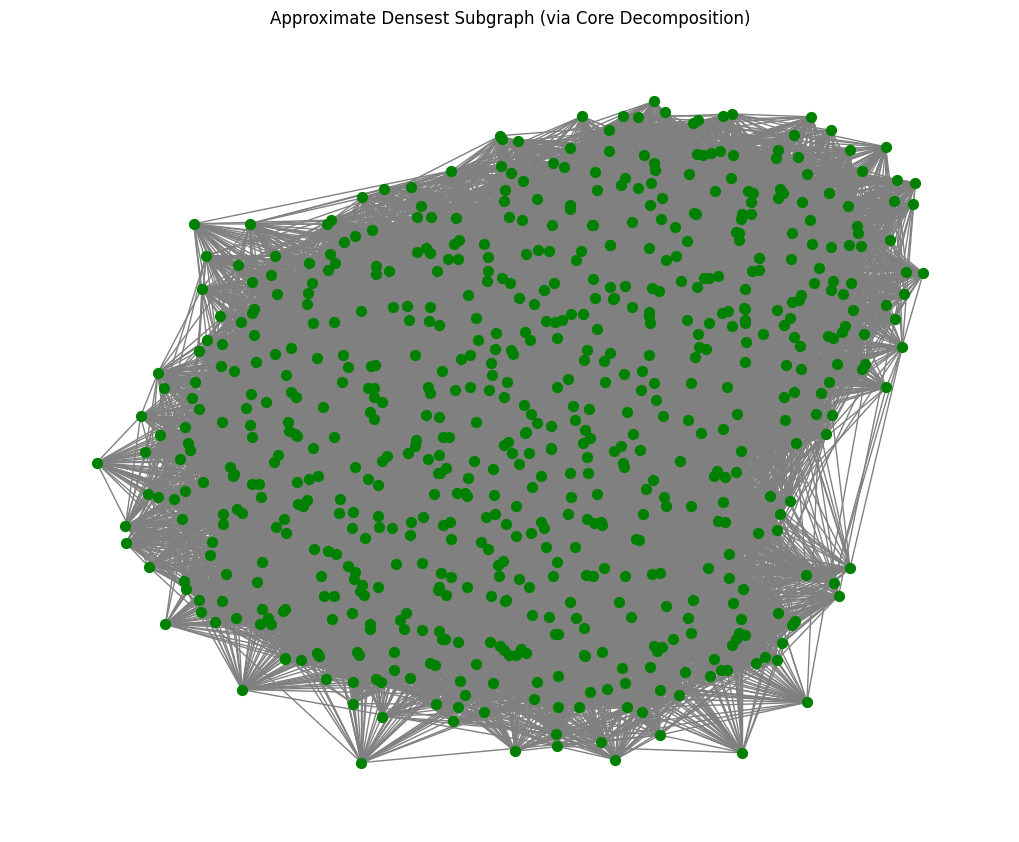

In [59]:
# Compute core numbers
core_nums = nx.core_number(B)

# Get subgraph induced by the highest core value (densest region)
max_core = max(core_nums.values())
densest_nodes = [n for n, c in core_nums.items() if c == max_core]
densest = B.subgraph(densest_nodes)

# Print summary
print(f"Densest subgraph nodes: {densest.number_of_nodes()}")
print(f"Densest subgraph edges: {densest.number_of_edges()}")
print(f"Density: {nx.density(densest):.4f}")

# Visualize
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(densest, seed=42)
nx.draw(
    densest, pos,
    node_size=50,
    node_color='green',
    edge_color='gray',
    with_labels=False
)
plt.title("Approximate Densest Subgraph (via Core Decomposition)")
plt.show()

The subgraph has 657 nodes and 21,966 edges, with an overall density of 0.1019. So 10% of all possible node pairs are connected within that subgraph.

Now I will reduce the size of the network with the island method. The island method works as described in the book:       

##### Imagine our network as an island with a complex terrain, where the height of each point on the terrain is defined by the value of a node (e.g., degree centrality) or edge (e.g., number of retweets). Now, let us imagine that the water level around this island is rising slowly, leaving portions of the landscape underwater. When the valleys in the island are flooded, the island essentially splits into smaller islands—revealing where the highest peaks are, and making these peaks smaller. It is possible to raise the water level so high that the entire island will disappear, so this method needs to be applied judiciously to reveal meaningful results. In terms of networks, this means that the giant component gets split up into smaller components, and areas with the strongest amount of  activity become their own components that can be analyzed separately. #####

In [68]:
# Function to virtually raise the water level. It takes a graph, applies a threshold, letting all edges above a certain value through, 
# and removing all others. Non-destructive, as it returns a copy of the original graph.

def trim_edges(g, min_vote=-1):
    """
    Keep only edges with vote >= min_vote
        -1 → all votes
         0 → neutral and support
        +1 → only support
    """
    g2 = nx.Graph()
    
    # Copy nodes with their attributes
    for n, attrs in g.nodes(data=True):
        g2.add_node(n, **attrs)
    
    # Copy edges that meet the threshold
    for u, v, edata in g.edges(data=True):
        if edata.get('vote', 0) >= min_vote:
            g2.add_edge(u, v, **edata)
    
    return g2


#############################################################################
# Island Function, Pg. 64 in Social Network Analysis for Startups (2011)
# Computes evenly spaced thresholds and produces a list of networks at each water level. 

def island_method(g, iterations=3):
    """
    Returns a list of [threshold, subgraph] pairs for evenly spaced thresholds.
    Thresholds go from min to max edge weights.
    """
    weights = [edata['vote'] for _, _, edata in g.edges(data=True)]
    if not weights:
        return []

    mn, mx = min(weights), max(weights)
    thresholds = np.linspace(mn, mx, iterations + 1)
    return [[t, trim_edges(g, t)] for t in thresholds]


#############################################################################
def island_method_categorical(g):
    """
    Runs island method for discrete vote thresholds (-1, 0, +1).
    """
    thresholds = [-1, 0, 1]
    return [[t, trim_edges(g, t)] for t in thresholds]

With the trimming and island method functions defined, apply them to the Network to see the most successful candidate at each threshold. It will reveal subgraphs of increasingly strong relationships by trimming weaker edges at each threshold. The bipartite network B connects voters to candidates, where each edge's vote' attribute represents how each voter supports each candidate (-1, 0, or +1). We can use the island method to filter out -1, only to show neutral or supporting votes, or filter out -1 and 0 to show core supporters. It makes more sense to think of the thresholds as inclusion categories, rather than continuous values.

In [66]:
# The island method applied to the voting categories; Interesting, but not too meaningful.
islands = island_method_categorical(B)

for t, sg in islands:
    print(f"Threshold {t} → Nodes: {sg.number_of_nodes()}, Edges: {sg.number_of_edges()}")

Threshold -1 → Nodes: 8601, Edges: 110087
Threshold 0 → Nodes: 7771, Edges: 88160
Threshold 1 → Nodes: 7546, Edges: 81664


The island method below looks at the Candidates and the threshold applied to them (-1, 0, +1). This trims the network to stronger support ties as the water level rises. A higher degree means the candidate received votes from more voters, and success means whether or not the candidate was promoted to be a Wikipedia Admin after the election.

In [72]:
# Run island method for discrete thresholds
threshold_graphs = island_method_categorical(B)

# Prepare a dataframe to store network size info for candidates
candidate_network_sizes = []

for threshold, G_sub in threshold_graphs:
    # Separate candidate nodes
    candidates_sub = [n for n, d in G_sub.nodes(data=True) if d['bipartite'] == 'candidate']
    
    for cand in candidates_sub:
        # Degree = number of voter connections (network size)
        degree = G_sub.degree(cand)
        
        # Check if the candidate was successful
        cand_id = cand.replace("c_", "")
        # Find election result
        success = None
        for elec in elections:
            if elec["candidate_id"] == cand_id:
                success = elec["result"]
                break
        
        candidate_network_sizes.append({
            "candidate_id": cand_id,
            "threshold": threshold,
            "degree": degree,
            "success": success
        })

# Convert to DataFrame
df_candidate_sizes = pd.DataFrame(candidate_network_sizes)
df_candidate_sizes

,candidate_id,threshold,degree,success
0,30,-1,27,1
1,54,-1,40,1
2,61,-1,22,1
3,6,-1,20,1
4,38,-1,17,1
...,...,...,...,...
7168,8276,1,2,0
7169,8277,1,2,0
7170,8271,1,0,0
7171,8263,1,3,0


From the dataframe above:

{candidate_id = 30, threshold = -1, degree = 27, success = 1}

This indicates that Candidate ID 30 is being analyzed. The threshold value of -1 means that all votes are counted, the degree value of 27 indicates that they had 27 voters connected to them, and the success value of 1 means the candidate was promoted to admin.

df_candidate_sizes allows us to compare the network sizes of successful vs unsuccessful candidates at each threshold. We can trim edges by raising the threshold to see which candidates relied on neutral or weak support.

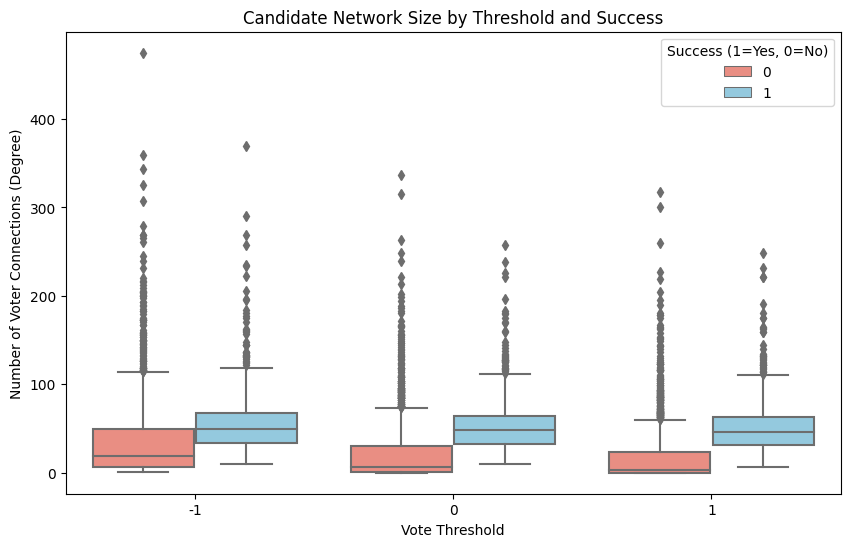

In [73]:
# Degree of success at each threshold
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_candidate_sizes,
    x='threshold',
    y='degree',
    hue='success',
    palette={0:'salmon', 1:'skyblue'}
)
plt.title("Candidate Network Size by Threshold and Success")
plt.xlabel("Vote Threshold")
plt.ylabel("Number of Voter Connections (Degree)")
plt.legend(title="Success (1=Yes, 0=No)")
plt.show()

I will adapt the island method so that the thresholds are based on vote counts, along with getting the candidates' vote score. This shows the most successful candidates at each election size cutoff. As the election size threshold increases, we see higher vote scores for more influential candidates.

In [97]:
# Count total votes per candidate
from collections import Counter

candidate_vote_counts = Counter([e['candidate_id'] for e in edges])

# Define maximum votes thresholds
vote_thresholds = [50, 100, 200, 300, 400, 500, 600, 700]

# Prepare list to hold "islands" per threshold
candidate_islands = []

for max_votes in vote_thresholds:
    # Select candidates with total_votes <= max_votes
    candidates_in_threshold = [cand_id for cand_id, total in candidate_vote_counts.items() if total <= max_votes]
    
    # Sort candidates by total votes (descending) to find "most active" candidates
    candidates_in_threshold_sorted = sorted(candidates_in_threshold, key=lambda x: candidate_vote_counts[x], reverse=True)
    
    # Create subgraph including only these candidates + their voters
    nodes_to_keep = set()
    for e in edges:
        cand_id = e['candidate_id']
        if cand_id in candidates_in_threshold_sorted:
            nodes_to_keep.add(f"c_{cand_id}")
            nodes_to_keep.add(f"v_{e['voter_id']}")
    
    G_sub = B.subgraph(nodes_to_keep).copy()
    
    candidate_islands.append({
        "max_votes": max_votes,
        "num_candidates": len(candidates_in_threshold_sorted),
        "num_nodes": G_sub.number_of_nodes(),
        "num_edges": G_sub.number_of_edges(),
        "candidates": candidates_in_threshold_sorted
    })

In [98]:
# See top 10 successful candidates by election size threshold


# Make sure vote_counts has candidate_id as string (to match your island lists)
vote_counts['candidate_id'] = vote_counts['candidate_id'].astype(str)

# See top 10 candidates by election size threshold with vote_score
for island in candidate_islands:
    print(f"Max Votes: {island['max_votes']}")
    print(f"Number of candidates: {island['num_candidates']}")
    print(f"Nodes in subgraph: {island['num_nodes']}, Edges: {island['num_edges']}")
    
    # Get top 10 candidates for this island
    top_candidates = island['candidates'][:10]
    
    # Lookup vote_score for each candidate
    top_candidates_scores = vote_counts[vote_counts['candidate_id'].isin(top_candidates)][['candidate_id','vote_score']]
    
    # Sort by vote_score descending
    top_candidates_scores = top_candidates_scores.sort_values('vote_score', ascending=False)
    
    print("Top candidates with vote_score:")
    print(top_candidates_scores.to_string(index=False))
    print("-------------------------------------------------")


Max Votes: 50
Number of candidates: 1514
Nodes in subgraph: 5164, Edges: 33550
Top candidates with vote_score:
candidate_id  vote_score
        1566          50
         871          50
        2073          49
        1419          48
         895          48
         859          42
        2273          37
        1758          37
        3150          35
        2106          25
-------------------------------------------------
Max Votes: 100
Number of candidates: 2180
Nodes in subgraph: 7470, Edges: 78702
Top candidates with vote_score:
candidate_id  vote_score
        2381         100
        2504          95
        4587          95
        1193          93
        1473          85
        1428          73
         974          71
        1990          67
        1836          65
        4983          45
-------------------------------------------------
Max Votes: 200
Number of candidates: 2345
Nodes in subgraph: 8233, Edges: 99324
Top candidates with vote_score:
candidate_id  v

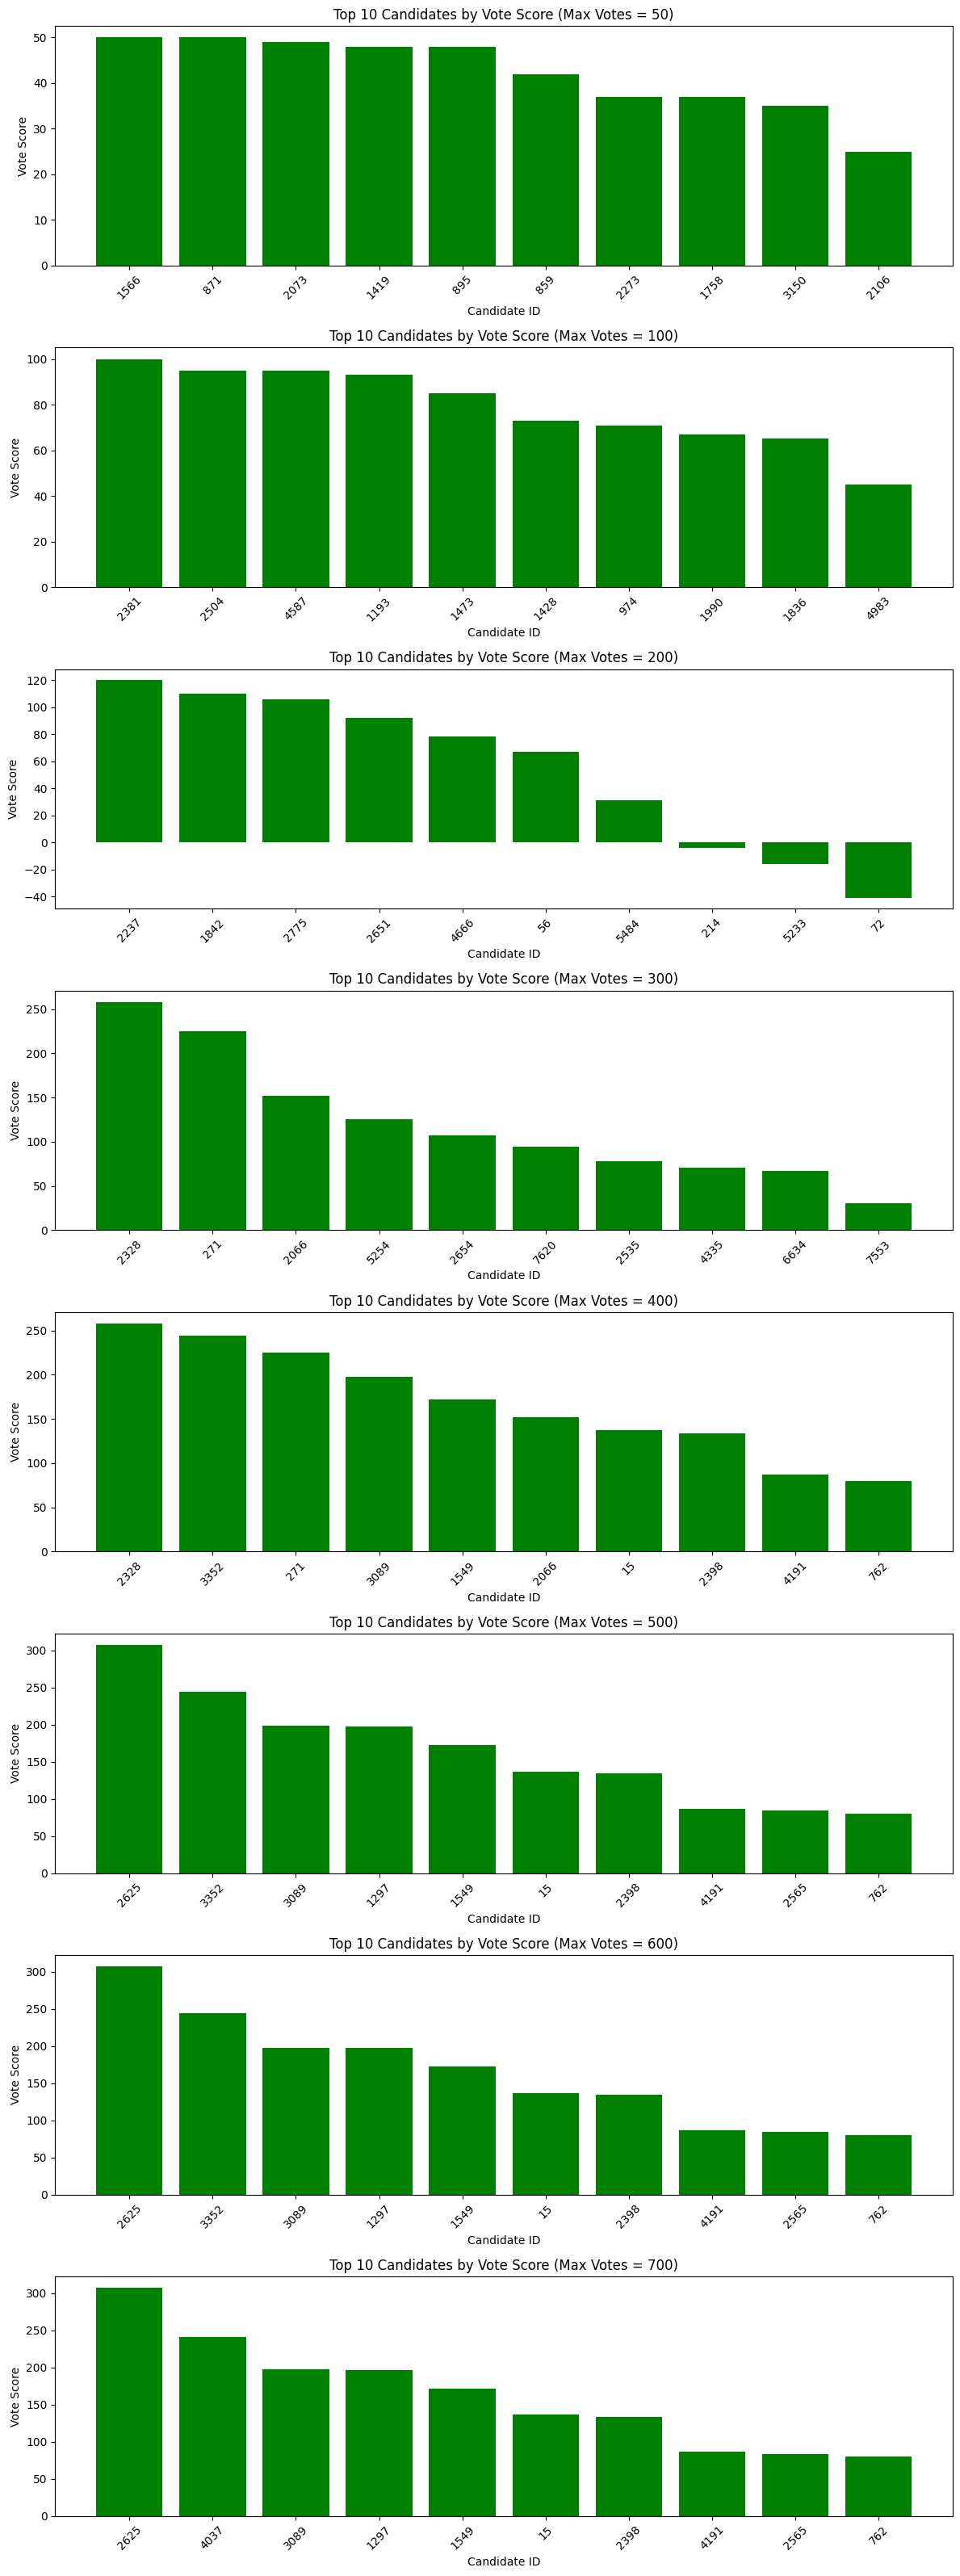

In [100]:

# Number of thresholds
n_thresholds = len(candidate_islands)

# Set figure size dynamically
fig, axes = plt.subplots(n_thresholds, 1, figsize=(12, 4 * n_thresholds), sharey=False)

if n_thresholds == 1:
    axes = [axes]  # Make iterable if only 1 threshold

for ax, island in zip(axes, candidate_islands):
    max_votes = island['max_votes']
    
    # Get top 10 candidates for this threshold
    top_candidates = island['candidates'][:10]
    
    # Get vote_score for these candidates
    top_scores = vote_counts[vote_counts['candidate_id'].isin(top_candidates)][['candidate_id', 'vote_score']]
    
    # Sort by vote_score descending
    top_scores = top_scores.sort_values('vote_score', ascending=False)
    
    # Bar plot
    ax.bar(top_scores['candidate_id'], top_scores['vote_score'], color='green')
    ax.set_title(f"Top 10 Candidates by Vote Score (Max Votes = {max_votes})")
    ax.set_xlabel("Candidate ID")
    ax.set_ylabel("Vote Score")
    ax.set_xticks(top_scores['candidate_id'])
    ax.set_xticklabels(top_scores['candidate_id'], rotation=45)

plt.tight_layout()
plt.show()